In [203]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time

In [235]:
start_data = time.time()

# Data load

In [236]:
from tqdm import tqdm
import numpy as np
from glob import glob

base_path = "1_reshape"
path_4 = sorted(glob(f"{base_path}/npy/encoder_4/*.npy"))  #讀資料夾路徑

data_4 = list()
trn_4 = list()
tst_4 = list()
val_4 = list()
dataname_4 = list()
trnname_4 = list()
tstname_4 = list()
valname_4 = list()

for i,  filename in tqdm(enumerate(path_4)): #讀檔名 tqdm:呈現for loop進度
    data = np.load(f"{filename}")
    data_4.append(data)
    day = path_4[i].split("\\")[1].split(".")[0].split("_")[1]
    t = '{:02}{:02}'.format(int(path_4[i].split("\\")[1].split(".")[0].split("_")[2])//4, int(path_4[i].split("\\")[1].split(".")[0].split("_")[2])%4*15)
    dataname_4.append(f"{day}_{t}")

203808it [02:37, 1296.53it/s]


In [237]:
import pandas as pd

data_4 = np.array(data_4).reshape((len(data_4),64))
trn_4 = data_4[:len(data_4)//10*7]
val_4 = data_4[len(data_4)//10*7:len(data_4)//10*9]
tst_4 = data_4[len(data_4)//10*9:]
trnname_4 = dataname_4[:len(dataname_4)//10*7]
valname_4 = dataname_4[len(dataname_4)//10*7:len(dataname_4)//10*9]
tstname_4 = dataname_4[len(dataname_4)//10*9:]

data_df = pd.DataFrame(data_4)
trn_df = pd.DataFrame(trn_4)
val_df = pd.DataFrame(val_4)
tst_df = pd.DataFrame(tst_4)

num_features = data_df.shape[1]

# Data Normalization

In [292]:
train_df = (trn_df - trn_df.mean()) / trn_df.std()
val_df = (val_df - val_df.mean()) / val_df.std()
test_df = (tst_df - tst_df.mean()) / tst_df.std()

# Input processing

Part 1

In [293]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Part 2

In [294]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

Part 3

In [295]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [296]:
def plot(self, model=None, plot_col=0, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Part 4

In [297]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [298]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=5):
#     early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
                      #callbacks=[early_stopping])
    return history

In [299]:
val_performance = {}
performance = {}

In [300]:
end_data = time.time()
print(format(end_data-start_data))

3249.2889199256897


# RNN

In [301]:
start_RNN = time.time()

In [302]:
RNN_input = WindowGenerator(input_width=1, label_width=1, shift=1)
RNN_input

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): None

In [303]:
model_RNN = keras.Sequential([
    layers.Input(shape=(None,64)),
#     layers.Embedding(input_dim=64, output_dim=64),
    layers.SimpleRNN(32, return_sequences=True),
    layers.Dense(64,activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    layers.SimpleRNN(32, return_sequences=True),
    layers.Dense(64,activation=tf.keras.layers.LeakyReLU(alpha=0.1))
])
model_RNN.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, None, 32)          3104      
                                                                 
 dense_26 (Dense)            (None, None, 64)          2112      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, None, 32)          3104      
                                                                 
 dense_27 (Dense)            (None, None, 64)          2112      
                                                                 
Total params: 10,432
Trainable params: 10,432
Non-trainable params: 0
_________________________________________________________________


In [304]:
history = compile_and_fit(model_RNN, RNN_input)

Epoch 1/20
4459/4459 [==============================] - 10s 2ms/step - loss: 0.1577 - mean_absolute_error: 0.2460 - val_loss: 0.0876 - val_mean_absolute_error: 0.1452
Epoch 2/20
4459/4459 [==============================] - 9s 2ms/step - loss: 0.1130 - mean_absolute_error: 0.1937 - val_loss: 0.0805 - val_mean_absolute_error: 0.1284
Epoch 3/20
4459/4459 [==============================] - 9s 2ms/step - loss: 0.1067 - mean_absolute_error: 0.1848 - val_loss: 0.0770 - val_mean_absolute_error: 0.1206
Epoch 4/20
4459/4459 [==============================] - 9s 2ms/step - loss: 0.1037 - mean_absolute_error: 0.1809 - val_loss: 0.0787 - val_mean_absolute_error: 0.1233
Epoch 5/20
4459/4459 [==============================] - 9s 2ms/step - loss: 0.1017 - mean_absolute_error: 0.1782 - val_loss: 0.0776 - val_mean_absolute_error: 0.1240
Epoch 6/20
4459/4459 [==============================] - 9s 2ms/step - loss: 0.1002 - mean_absolute_error: 0.1761 - val_loss: 0.0778 - val_mean_absolute_error: 0.1261
Epo

In [305]:
model_RNN.evaluate(RNN_input.val)
model_RNN.evaluate(RNN_input.test,verbose = 0)

1274/1274 [==============================] - 2s 1ms/step - loss: 0.0687 - mean_absolute_error: 0.1110


In [306]:
end_RNN = time.time()
print(format(end_RNN-start_RNN))

180.71551251411438


# GRU

In [307]:
start_GRU = time.time()

In [308]:
GRU_input = WindowGenerator(input_width=1, label_width=1, shift=1)
GRU_input

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): None

In [309]:
model_GRU = keras.Sequential([
    layers.Input(shape=(None,64)),
#     layers.Embedding(input_dim=64, output_dim=64),
    layers.GRU(32, return_sequences=True),
    layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    layers.GRU(32, return_sequences=True),
    layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1))
])
model_GRU.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, None, 32)          9408      
                                                                 
 dense_28 (Dense)            (None, None, 64)          2112      
                                                                 
 gru_15 (GRU)                (None, None, 32)          9408      
                                                                 
 dense_29 (Dense)            (None, None, 64)          2112      
                                                                 
Total params: 23,040
Trainable params: 23,040
Non-trainable params: 0
_________________________________________________________________


In [310]:
history = compile_and_fit(model_GRU, GRU_input)

Epoch 1/20
4459/4459 [==============================] - 17s 3ms/step - loss: 0.1581 - mean_absolute_error: 0.2427 - val_loss: 0.0834 - val_mean_absolute_error: 0.1336
Epoch 2/20
4459/4459 [==============================] - 22s 5ms/step - loss: 0.1118 - mean_absolute_error: 0.1916 - val_loss: 0.0788 - val_mean_absolute_error: 0.1266
Epoch 3/20
4459/4459 [==============================] - 21s 5ms/step - loss: 0.1048 - mean_absolute_error: 0.1824 - val_loss: 0.0742 - val_mean_absolute_error: 0.1169
Epoch 4/20
4459/4459 [==============================] - 21s 5ms/step - loss: 0.1013 - mean_absolute_error: 0.1775 - val_loss: 0.0738 - val_mean_absolute_error: 0.1182
Epoch 5/20
4459/4459 [==============================] - 21s 5ms/step - loss: 0.0993 - mean_absolute_error: 0.1748 - val_loss: 0.0775 - val_mean_absolute_error: 0.1240
Epoch 6/20
4459/4459 [==============================] - 21s 5ms/step - loss: 0.0978 - mean_absolute_error: 0.1728 - val_loss: 0.0751 - val_mean_absolute_error: 0.117

In [311]:
model_GRU.evaluate(GRU_input.val)
model_GRU.evaluate(GRU_input.test)

638/638 [==============================] - 2s 2ms/step - loss: nan - mean_absolute_error: nan


In [313]:
end_GRU = time.time()
print(format(end_GRU-start_GRU))

424.24466586112976


In [315]:
pred_RNN = model_RNN.predict(RNN_input.val)
pred_GRU = model_GRU.predict(GRU_input.val)
pred_RNN = pred_RNN.reshape(len(pred_RNN),64)[10:10+96]
pred_GRU = pred_GRU.reshape(len(pred_GRU),64)[10:10+96]

1274/1274 [==============================] - 4s 2ms/step


In [316]:
decoder = tf.keras.models.load_model("1_reshape/model/decoder_4.h5")

In [317]:
decoded_RNN = decoder(pred_RNN).numpy().reshape(len(pred_RNN),33,25)
decoded_GRU = decoder(pred_GRU).numpy().reshape(len(pred_GRU),33,25)
decoder_true = decoder(val_4[:96]).numpy().reshape(96,33,25)

In [318]:
RNN_loss = list()
GRU_loss = list()
for i in range(96):
    RNN_loss.append(np.sum((decoder_true[i] - decoded_RNN[i]) ** 2)/33/25)
    GRU_loss.append(np.sum((decoder_true[i] - decoded_GRU[i]) ** 2)/33/25)
    
# np.save(f"{base_path}/npy/loss_4",loss)

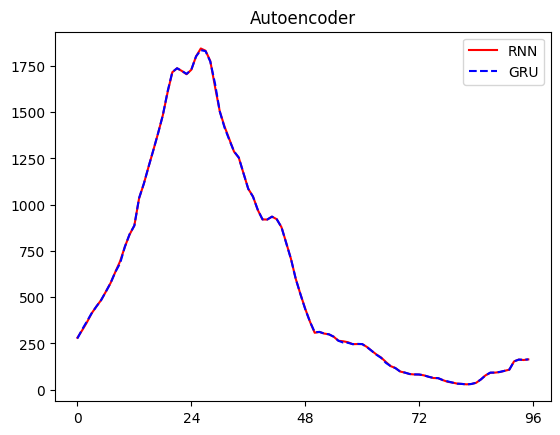

In [319]:
import matplotlib.pyplot as plt
plt.title("Autoencoder")
plt.plot(RNN_loss,'r',label = "RNN")
plt.plot(GRU_loss,'b--',label = "GRU")
plt.xticks(np.arange(0,96+1,24))
# plt.yticks(np.arange(0,0.2,0.05))
# plt.title("Loss_4")
# plt.savefig(f"{base_path}/result/loss_4")
plt.legend()
plt.show()

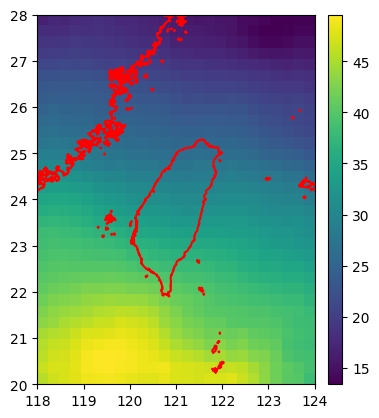

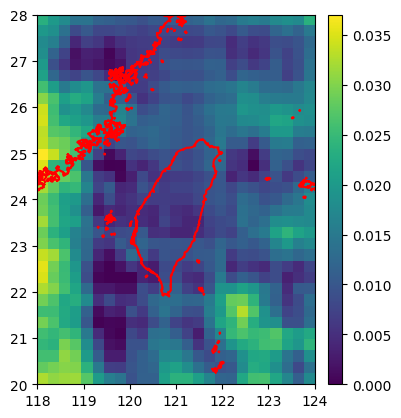

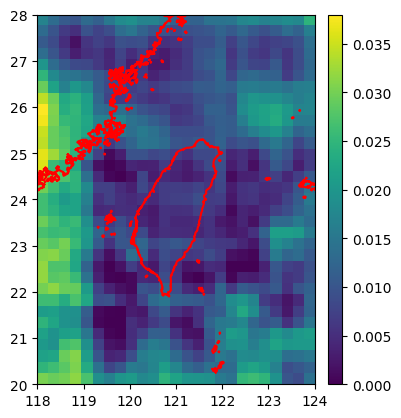

In [330]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
n = np.random.randint(len(decoder_true))

asian_map = np.load("asian_map.npy")
fig = plt.figure() # 創建圖形物件

ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cmap = "jet"

cax.cla()
tx, ty = [118,20]
ax.set_xlim(118,124)
ax.set_ylim(20,28)

im = ax.imshow(decoder_true[n], origin = "lower", zorder = 1, extent = (tx,tx+6,ty,ty+8))  #-------------------Here to change the colorbar range
ax.plot(asian_map[:,0], asian_map[:,1], c = "r", zorder = 2)
fig.colorbar(im, cax=cax)




fig = plt.figure() # 創建圖形物件

ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cmap = "jet"

cax.cla()
tx, ty = [118,20]
ax.set_xlim(118,124)
ax.set_ylim(20,28)

im = ax.imshow(decoded_RNN[n], origin = "lower", zorder = 1, extent = (tx,tx+6,ty,ty+8))  #-------------------Here to change the colorbar range
ax.plot(asian_map[:,0], asian_map[:,1], c = "r", zorder = 2)
fig.colorbar(im, cax=cax)




fig = plt.figure() # 創建圖形物件

ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cmap = "jet"

cax.cla()
tx, ty = [118,20]
ax.set_xlim(118,124)
ax.set_ylim(20,28)

im = ax.imshow(decoded_GRU[n], origin = "lower", zorder = 1, extent = (tx,tx+6,ty,ty+8))  #-------------------Here to change the colorbar range
ax.plot(asian_map[:,0], asian_map[:,1], c = "r", zorder = 2)
fig.colorbar(im, cax=cax)

# plt.figure()
# plt.title("Autoencoder")
# plt.imshow(decoder_true[n],origin="lower")
# plt.colorbar()
# plt.figure()
# plt.title("RNN")
# plt.imshow(decoded_RNN[n],origin="lower")
# plt.colorbar()
# plt.figure()
# plt.title("GRU")
# plt.imshow(decoded_GRU[n],origin="lower")
# plt.colorbar()